In [1]:
import torch
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("..")
from torch import nn, optim
from torch.nn import functional as F
from src.datasets.dataset_wrappers import AugRepresentationDataset
from IPython.display import display,clear_output
import tqdm
from sklearn.metrics import normalized_mutual_info_score as nmi
import umap

In [2]:
#import the data
org = torch.load("../originals.pt")
aug = torch.load("../augmentations.pt")
labels = torch.load("../labels.pt")
nn_indices = torch.load("../nn_indices.pt")

dataset = AugRepresentationDataset(aug,org,labels)



In [3]:
reducer = umap.UMAP(n_components=2,random_state=42,metric="cosine")
emb = reducer.fit_transform(org)


/home/alex/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [4]:
dataloader = DataLoader(dataset,batch_size=1000,shuffle=True)

In [9]:
def clustering_loss(p1,p2,x1,x2,lamb=1.0,tau=0.05,eps=1e-4):

    z1,z2 = F.normalize(x1,p=2,dim=1),F.normalize(x2,p=2,dim=1)
    p1,p2 = F.softmax(p1,dim=1),F.softmax(p2,dim=1)
    D,K = p1.shape
    P_highdim = torch.exp((z1 @ z2.t()-1)/tau)
    Q_highdim = 1-torch.exp((z1 @ z2.t()-1)/lamb)
    P_lowdim  = p1 @ p2.t()

    
    Q_lowdim = 1-P_lowdim

    #compute PlogP and QlogQ
    PlogP = -(P_highdim*torch.log(P_lowdim+eps)).mean()
    QlogQ = -(Q_highdim*torch.log(Q_lowdim+eps)).mean()

    #compute the loss
    structure_loss = PlogP + QlogQ

    #joint probability dist
    P = (p1.unsqueeze(2) * p2.unsqueeze(1)).mean(dim=0)
    P = 1/p1.shape[0] * p1.T @ p2

    #marginal probabilities
    P1 = p1.mean(dim=0).unsqueeze(1)
    P2 = p2.mean(dim=0).unsqueeze(0)

    #compute the mutual information
    MI = (P * (torch.log(P + eps) - torch.log((P1+eps)*(P2+eps)))).sum()

    return structure_loss - MI


In [10]:
from src.models.clustering import MLP_dict    

In [11]:
1.2**(-np.arange(10)-3)

array([0.5787037 , 0.48225309, 0.40187757, 0.33489798, 0.27908165,
       0.23256804, 0.1938067 , 0.16150558, 0.13458799, 0.11215665])

In [12]:
model = MLP_dict(K_range=[15],lamb_range=np.arange(15),num_copies=15)
device = 'cuda'
model.to(device)

MLP_dict(
  (mlp_dict): ModuleDict(
    ((0, 15, 0)): MlpClassifier(
      (input_block): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.25, inplace=False)
      )
      (hidden_blocks): ModuleList(
        (0): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.25, inplace=False)
        )
      )
      (output_block): Sequential(
        (0): Linear(in_features=512, out_features=15, bias=True)
      )
    )
    ((0, 15, 1)): MlpClassifier(
      (input_block): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU

In [13]:
evals = [ ]
losses = []

optimizer = optim.Adam(model.parameters(),lr=0.001)
dataloader = DataLoader(dataset,batch_size=500,shuffle=True)
loss_dict = {key:[] for key in model.keys}
for epoch in range(100):
    temp_loss = {key:[] for key in model.keys}
    
    loading_bar = tqdm.tqdm(dataloader,desc=f"Epoch {epoch+1}")
    for x1,x2,x,y in loading_bar:
        optimizer.zero_grad()
        x1,x2 = x1.to(device),x2.to(device)
        x = x.to(device)
        p1,p2 = model(x1),model(x2)
        loss = 0
        for key in p1.keys():
            lossval = clustering_loss(p1[key],p2[key],x1,x2,tau=1.2**(-key[0]+3),lamb=1.2**(-key[2]+3))
            loss_dict[key].append(lossval.item())
            loss += lossval
        loss = loss/len(p1.keys())
        loss.backward()
        optimizer.step()
    
    for key in temp_loss.keys():
        loss_dict[key].append(np.mean(temp_loss[key]))
    
    

Epoch 1: 100%|██████████| 85/85 [00:52<00:00,  1.63it/s]
/home/alex/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Epoch 2:  16%|█▋        | 14/85 [00:08<00:45,  1.56it/s]


KeyboardInterrupt: 

In [14]:
1.2**-6

0.3348979766803842

In [15]:
#get all the evals
test_dataloader = DataLoader(dataset,batch_size=1000,shuffle=False)
predictions = {key:[] for key in p1.keys()}
with torch.no_grad():
    for x1,x2,x,y in test_dataloader:
        x = x.to(device)
        p = model(x)
        for key in p.keys():
            predictions[key].append(p[key].argmax(dim=1).cpu())

predictions = {key:torch.cat(predictions[key]) for key in predictions.keys()}
eval_mat = torch.zeros(15,15)
for key in predictions.keys():
    eval_mat[key[0],key[2]] = nmi(predictions[key],labels)




<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1691732/621100611.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$")


Text(50.722222222222214, 0.5, '$\\tau$')

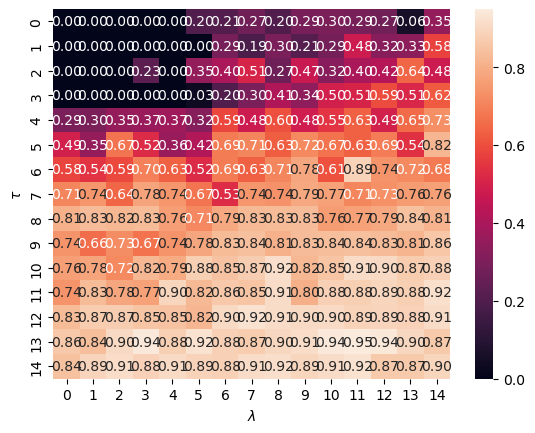

In [16]:
sns.heatmap(eval_mat,annot=True,fmt='.2f')
plt.xlabel("$\lambda$")
plt.ylabel("$\\tau$")

In [39]:
eval_mat.flatten()

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.9107, 0.9183, 0.9257, 0.9267, 0.9402, 0.9293, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9114, 0.9238, 0.9245,
        0.9282, 0.9326, 0.9275, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.8946, 0.9182, 0.9237, 0.9275, 0.9309, 0.9297, 0.9232,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8914, 0.9167,
        0.9211, 0.9256, 0.9251, 0.9316, 0.9255, 0.9138, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.8122, 0.8984, 0.9193, 0.9256, 0.9264, 0.9399,
        0.9260, 0.9140, 0.9076, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8900,
        0.8967, 0.9209, 0.9235, 0.9245, 0.9318, 0.9266, 0.9211, 0.9099, 0.8949,
        0.0000, 0.0000, 0.0000, 0.0000, 0.8819, 0.8966, 0.9207, 0.9220, 0.9225,
        0.9336, 0.9271, 0.9217, 0.9124, 0.8982, 0.8849, 0.0000, 0.0000, 0.0000,
        0.0000, 0.8934, 0.9152, 0.9219, 

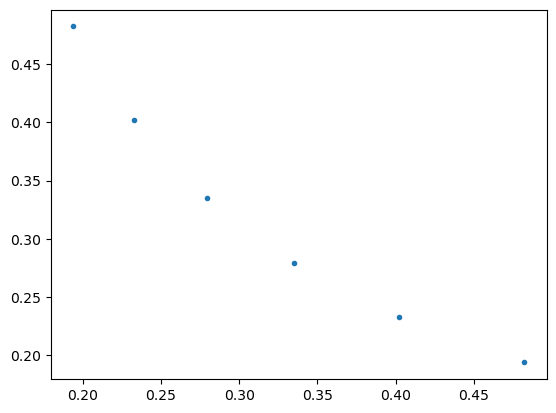

In [ ]:
tau = 1.2**(-np.arange(6)-4)
lamb = 
plt.plot(tau,tau[::-1],'.')


<Axes: >

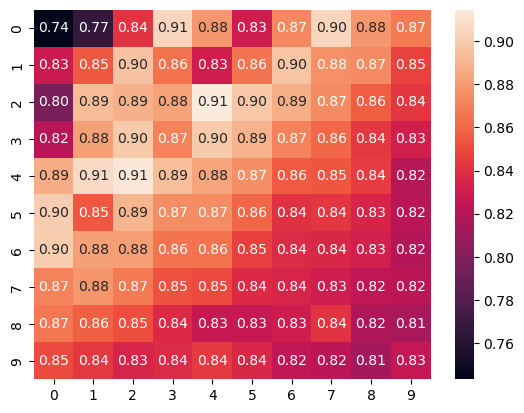

In [183]:
sns.heatmap(eval_mat,annot=True,fmt='.2f')

In [ ]:
1.2**(-np.arange(10)-4)

array([0.48225309, 0.40187757, 0.33489798, 0.27908165, 0.23256804,
       0.1938067 , 0.16150558, 0.13458799, 0.11215665, 0.09346388])

In [168]:
1.1**(-np.arange(10)-4)

array([0.68301346, 0.62092132, 0.56447393, 0.51315812, 0.46650738,
       0.42409762, 0.38554329, 0.3504939 , 0.31863082, 0.28966438])

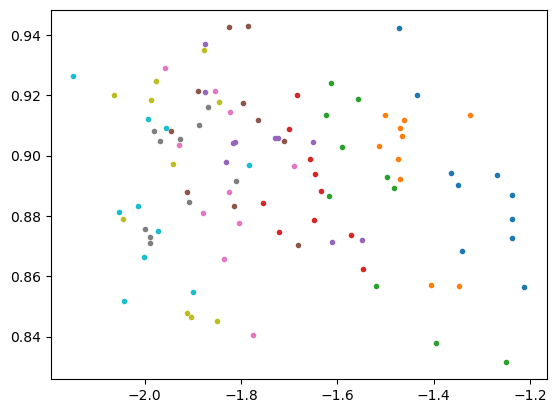

In [169]:
for key in loss_dict.keys():
    plt.plot(loss_dict[key][-1],nmi(predictions[key],labels),'.')

<Axes: title={'center': 'Predicted Clusters (Neural Network)'}>

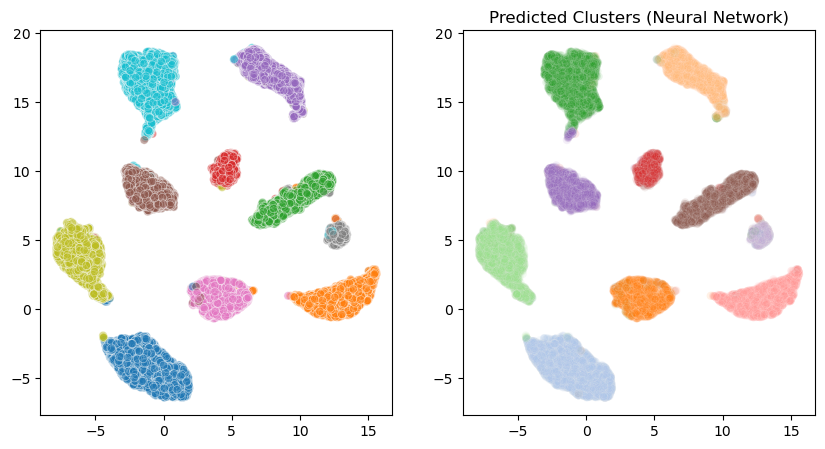

In [19]:
pred_clus = predictions[(13,15,11)]
f,a = plt.subplots(1,2,figsize=(10,5))
a[1].set_title("Predicted Clusters (Neural Network)")
sns.scatterplot(x=emb[:,0],y=emb[:,1],hue=labels,palette="tab10",alpha=0.5,ax=a[0],legend=False)
sns.scatterplot(x=emb[:,0],y=emb[:,1],hue=pred_clus,palette="tab20",alpha=0.1,ax=a[1],legend=False)


<Axes: ylabel='Count'>

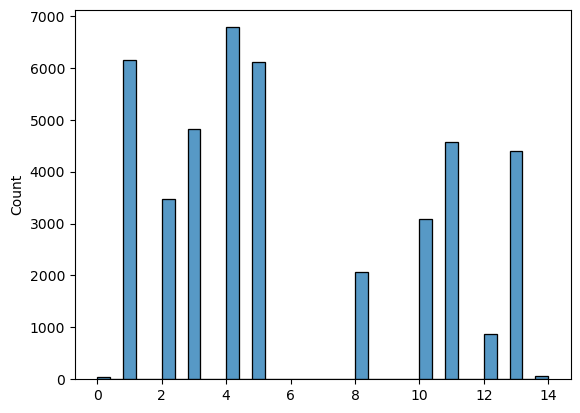

In [20]:
sns.histplot(pred_clus)

In [59]:
nmi(pred_clus,labels)

0.9383468235283375

<Axes: title={'center': 'Kmeans on normalized representations'}>

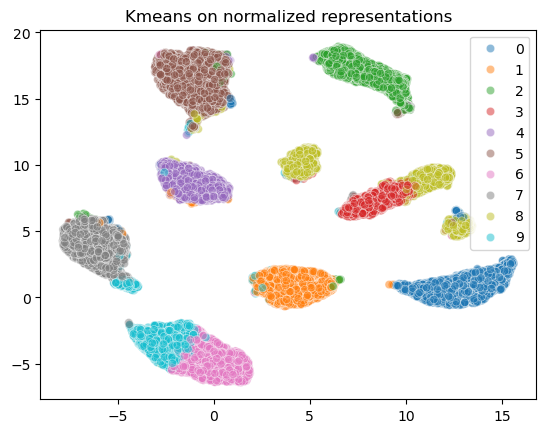

In [ ]:
#get the representations by labels
norm_org = F.normalize(org,p=2,dim=1)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10,random_state=42)
kmeans.fit(norm_org)
kmeans_labels = kmeans.labels_
plt.title("Kmeans on normalized representations")
sns.scatterplot(x=emb[:,0],y=emb[:,1],hue=kmeans_labels,palette="tab10",alpha=0.5,legend=True)



Stats for P_sym:
  Max value: 1.0000
  Mean non-zero value: 0.3049
  Median non-zero value: 0.1935
  Sparsity: 0.0005
  Values > 0.5: 166248
  Values > 0.1: 711816


In [ ]:
np.sort(np.unique(P_sym_dense))

In [ ]:
sim27 = (reps[2] @ reps[7].T)
sim22 = (reps[2] @ reps[2].T)
sim77 = (reps[7] @ reps[7].T)

In [ ]:
sim27.mean(),sim22.mean(),sim77.mean()

(tensor(0.6576), tensor(0.7939), tensor(0.8823))